# Import required packages

In [6]:
#https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632
# https://github.com/FrancescoSaverioZuppichini/ViT
#https://einops.rocks/1-einops-basics/

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

# we need a picture

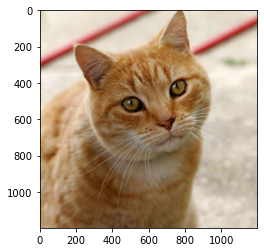

In [7]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)

# preprocess the image

In [8]:
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

# break-down the image in multiple patches and flatten them

In [9]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

# project them using a normal linear layer and add the cls token and the position embedding

In [10]:
#class PatchEmbedding(nn.Module):
#    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
#        self.patch_size = patch_size
#        super().__init__()
#        self.projection = nn.Sequential(
#            # break-down the image in s1 x s2 patches and flat them
#            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
#            nn.Linear(patch_size * patch_size * in_channels, emb_size)
#        )
                
#    def forward(self, x: Tensor) -> Tensor:
#        x = self.projection(x)
#        return x
    
#PatchEmbedding()(x).shape

# with convolutional layer as original paper
# adding Cls and position embedding
# We added the position embedding in the .positions field and sum it to the patches in the .
#forward function

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape


torch.Size([1, 197, 768])

# Implement Transformer (ViT only the Encoder in ViT)

# Attention

In [11]:
#So, the attention takes three inputs, the famous queries, keys, and values, and computes
#the attention matrix using queries and values and use it to “attend” to the values. 
#In this case, we are using multi-head attention meaning that the computation is split 
#across n heads with smaller input size.

# So, step by step. We have 4 fully connected layers, one for queries, keys, values, 
#and a final one dropout.

#use the product between the queries and the keys to knowing “how much” each element is
# the sequence in important with the rest. Then, we use this information to scale the values.

#The forward method takes as input the queries, keys, and values from the previous layer and
#projects them using the three linear layers. Since we implementing multi heads attention, we
#have to rearrange the result in multiple heads.

#This is done by using rearrange from einops.
#Queries, Keys and Values are always the same, so for simplicity, I have only one input ( x).

#The resulting keys, queries, and values have a shape of BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE.

#To compute the attention matrix we first have to perform matrix multiplication between queries and
#keys, a.k.a sum up over the last axis. This can be easily done using torch.einsum

#The resulting vector has the shape BATCH, HEADS, QUERY_LEN, KEY_LEN. Then the attention is
#finally the softmax of the resulting vector divided by a scaling factor based on the size of
#the embedding.

#Lastly, we use the attention to scale the values

#and we obtain a vector of size BATCH HEADS VALUES_LEN, EMBEDDING_SIZE. We concat the heads 
#together and we finally return the results.

#Note we can use a single matrix to compute in one shot queries, keys and values.

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

# Residuals

In [13]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [14]:
#The attention’s output is passed to a fully connected layer composed of two layers that upsample by a factor
#of expansion the input

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

# Creat Transformer Encoder with ResidualAdd

In [15]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))
        
        
 # test it
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [16]:
# In ViT only the Encoder part of the original transformer is used. Easily, the encoder 
#is L blocks of TransformerBlock.
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# The last layer: a normal fully connect 


In [17]:
#that gives the class probability. It first performs a basic mean over the whole sequence.
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [18]:
#We can compose PatchEmbedding, TransformerEncoder and ClassificationHead to
#create the final ViT architecture.

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [19]:
# We can use torchsummary to check the number of parameters
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19